## Introduction

Is school performance predicted by socioeconomic factors? This notebook attempts to clean and prepare data for the purpose of being analysed to answer this question.

## Import libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

## The data

This project utilizes two data sets. The primary data set is the EdGap data set from [EdGap.org](https://www.edgap.org/#5/37.875/-96.987). This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district. The secondary data set is basic information about each school from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp).





### EdGap data

All socioeconomic data (household income, unemployment, adult educational attainment, and family structure) are from the Census Bureau's American Community Survey.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) report that ACT and SAT score data is from each state's department of education or some other public data release. The nature of the other public data release is not known.

The quality of the census data and the department of education data can be assumed to be reasonably high.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) do not indicate that they processed the data in any way. The data were assembled by the [EdGap.org](https://www.edgap.org/#5/37.875/-96.987) team, so there is always the possibility for human error. Given the public nature of the data, we would be able to consult the original data sources to check the quality of the data if we had any questions.

### School information data

The school information data is from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). This data set consists of basic identifying information about schools and can be assumed to be of reasonably high quality. As for the EdGap.org data, the school information data is public, so we would be able to consult the original data sources to check the quality of the data if we had any questions.


## Load the data

Load the EdGap
 data set

In [113]:
edgap = pd.read_excel('https://github.com/galenegan/DATA-3320/raw/main/education/EdGap_data.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Load the school information data

In [114]:
!wget -O school_info.csv https://drive.usercontent.google.com/u/0/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP&export=download

--2024-04-23 00:33:23--  https://drive.usercontent.google.com/u/0/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.16.132, 2607:f8b0:4004:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.16.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP [following]
--2024-04-23 00:33:23--  https://drive.usercontent.google.com/uc?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP [following]
--2024-04-23 00:33:23--  https://drive.usercontent.google.com/download?id=1HvW2w-o2XZzCm4KTvnb1Bb3BvoAa14BP
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaitin

In [115]:
school_info = pd.read_csv('school_info.csv', encoding= 'unicode_escape')

<ipython-input-115-9aca6f144c98>:1: DtypeWarning: Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  school_info = pd.read_csv('school_info.csv', encoding= 'unicode_escape')


## Rename columns

Rename the columns `NCESSCH School ID`, `CT Pct Adults with College Degree`,`CT Unemployment Rate`, `CT Pct Childre In Married Couple Family`, `CT Median Household Income`, `School ACT average (or equivalent if SAT score)`, `School Pct Free and Reduced Lunch` to `id`, `percent_college`, `rate_unemployment`, `percent_married`, `median_income`, `average_act`, `percent_lunch`

In [116]:
edgap = edgap.rename(columns={"NCESSCH School ID":"id",
              "CT Pct Adults with College Degree":"percent_college",
              "CT Unemployment Rate":"rate_unemployment",
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

Rename the columns `SCHOOL_YEAR`, `NCESSCH`, `MSTATE`, `MZIP`, `SCH_TYPE_TEXT`, `LEVEL` to `year`, `id`, `state`, `zip_code`, `school_type`, `school_level`

In [117]:
school_info = school_info.rename(columns={"SCHOOL_YEAR":"year",
              "NCESSCH":"id",
              "MSTATE":"state",
              "MZIP":"zip_code",
              "SCH_TYPE_TEXT":"school_type",
              "LEVEL":"school_level"})

## Explore the contents of the data sets

### Edgap

In [118]:
edgap

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641
...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583


In [119]:
edgap.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
count,7.986000e+03,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000
mean,3.321869e+11,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651
std,1.323638e+11,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545
25%,2.105340e+11,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501
50%,3.600085e+11,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570
75%,4.226678e+11,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447
max,5.605830e+11,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729


It seems we have some negative average_act and percent_lunch values, which isn't possible. We also have at least one 0.0 for percent_married and at least one 1.0 for percent_college and percent_married. These values aren't impossible, but improbable.

In [120]:
edgap.dtypes

id                     int64
rate_unemployment    float64
percent_college      float64
percent_married      float64
median_income        float64
average_act          float64
percent_lunch        float64
dtype: object

### School info

In [121]:
school_info

,year,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,...,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,school_level,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoyah Sch - Chalkville Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
1,2016-2017,1,ALABAMA,AL,Camps,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
3,2016-2017,1,ALABAMA,AL,Wallace Sch - Mt Meigs Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
4,2016-2017,1,ALABAMA,AL,McNeel Sch - Vacca Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102178,2016-2017,78,U.S. VIRGIN ISLANDS,VI,GLADYS A. ABRAHAM ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102179,2016-2017,78,U.S. VIRGIN ISLANDS,VI,ULLA F MULLER ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102180,2016-2017,78,U.S. VIRGIN ISLANDS,VI,YVONNE BOWSKY ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102181,2016-2017,78,U.S. VIRGIN ISLANDS,VI,CANCRYN JUNIOR HIGH SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,07,08,Middle,As reported


In [122]:
school_info.describe()

,FIPST,UNION,id,SCHID
count,102183.000000,2533.000000,1.021810e+05,1.021810e+05
mean,29.018496,207.158310,2.913297e+11,2.904893e+06
std,16.844778,125.767108,1.684048e+11,1.684249e+06
min,1.000000,1.000000,1.000020e+10,1.000010e+05
25%,13.000000,50.000000,1.302550e+11,1.302169e+06
50%,29.000000,300.000000,2.911250e+11,2.900753e+06
75%,42.000000,300.000000,4.220250e+11,4.206624e+06
max,78.000000,301.000000,7.800030e+11,7.800037e+06


In [123]:
list(school_info.columns)

['year',
 'FIPST',
 'STATENAME',
 'ST',
 'SCH_NAME',
 'LEA_NAME',
 'STATE_AGENCY_NO',
 'UNION',
 'ST_LEAID',
 'LEAID',
 'ST_SCHID',
 'id',
 'SCHID',
 'MSTREET1',
 'MSTREET2',
 'MSTREET3',
 'MCITY',
 'state',
 'zip_code',
 'MZIP4',
 'LSTREET1',
 'LSTREET2',
 'LSTREET3',
 'LCITY',
 'LSTATE',
 'LZIP',
 'LZIP4',
 'PHONE',
 'WEBSITE',
 'SY_STATUS',
 'SY_STATUS_TEXT',
 'UPDATED_STATUS',
 'UPDATED_STATUS_TEXT',
 'EFFECTIVE_DATE',
 'school_type',
 'SCH_TYPE',
 'RECON_STATUS',
 'OUT_OF_STATE_FLAG',
 'CHARTER_TEXT',
 'CHARTAUTH1',
 'CHARTAUTHN1',
 'CHARTAUTH2',
 'CHARTAUTHN2',
 'NOGRADES',
 'G_PK_OFFERED',
 'G_KG_OFFERED',
 'G_1_OFFERED',
 'G_2_OFFERED',
 'G_3_OFFERED',
 'G_4_OFFERED',
 'G_5_OFFERED',
 'G_6_OFFERED',
 'G_7_OFFERED',
 'G_8_OFFERED',
 'G_9_OFFERED',
 'G_10_OFFERED',
 'G_11_OFFERED',
 'G_12_OFFERED',
 'G_13_OFFERED',
 'G_UG_OFFERED',
 'G_AE_OFFERED',
 'GSLO',
 'GSHI',
 'school_level',
 'IGOFFERED']

In [124]:
school_info.dtypes

year            object
FIPST            int64
STATENAME       object
ST              object
SCH_NAME        object
                 ...  
G_AE_OFFERED    object
GSLO            object
GSHI            object
school_level    object
IGOFFERED       object
Length: 65, dtype: object

Frankly, I do not know what much of the data in this set means. I'm going to continue to assume the data is of reasonably high quality. Arguably the school year could be converted to a data time, or a variable for ordering of school years could be useful in some contexts, but since the data present is only from the 2016-2017 school year I don't think it is necessary.

## Convert data types, if necessary

No data types are in need of conversion.

## Quality Control

Check for out-of-range values or values that do not match what we want to analyze. Either set values to `NaN` or remove the observations, as appropriate.

In [125]:
# List all the rows with a negative average_act or percent_lunch
edgap[(edgap.average_act < 0) | (edgap.percent_lunch < 0)]

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
1398,173897003956,0.160519,0.673671,0.554577,68924.0,16.500000,-0.004777
1422,174098004105,0.040594,0.789430,0.831663,69466.0,21.400000,-0.007792
2336,250279000217,0.027694,0.955152,1.000000,111923.0,16.025641,-0.022670
2514,251104001774,0.051298,0.588981,0.795222,50530.0,22.545788,-0.026866
2718,260807004379,0.154488,0.545110,0.772984,43750.0,18.700000,-0.017241
3277,291254000516,0.159223,0.494906,0.538893,35299.0,21.200000,-0.015986
3519,293180002224,0.067823,0.555265,0.675737,64603.0,21.300000,-0.037815
3773,341269003101,0.153491,0.284550,0.329727,23783.0,-3.070818,0.796380
3776,341269003107,0.126452,0.321543,0.253482,31563.0,-3.070818,0.847015
3777,341269003109,0.060403,0.344922,0.138728,25000.0,-3.070818,0.837104


In [126]:
# Convert these invalid values with NaN
edgap[(edgap.average_act < 0) | (edgap.percent_lunch < 0)] = pd.NA

In [127]:
# Drop rows with NaN id or average_act
edgap.dropna(subset=['id'], inplace=True)

Since the id NaN values can't be imputed, they should be dropped. average_act shouldn't be imputed as it is the target for prediction.

In [128]:
# Count how many nans there are
edgap.isna().sum().sum()

72

There are relatively few nans compared to the number of rows (almost 8000) in our data set. We could drop them without much worry, but we'll impute them later.

## Select relevant subsets of the data

The school information data set contains a lot of information. We only need the year, school identity, location, and school type information.

Keep the columns `year`, `id`, `state`, `zip_code`, `school_type`, `school_level`


In [129]:
# Get a list of all the columns that need to be dropped
good_columns = ['year', 'id', 'state', 'zip_code', 'school_type', 'school_level']
all_columns = list(school_info.columns)
bad_columns = []
for column in all_columns:
  if column not in good_columns:
    bad_columns.append(column)
school_info.drop(columns=bad_columns, inplace=True)

In [130]:
school_info.columns

Index(['year', 'id', 'state', 'zip_code', 'school_type', 'school_level'], dtype='object')

## Are the data suitable for answering the question?

Display pairplots for the variables in edgap.

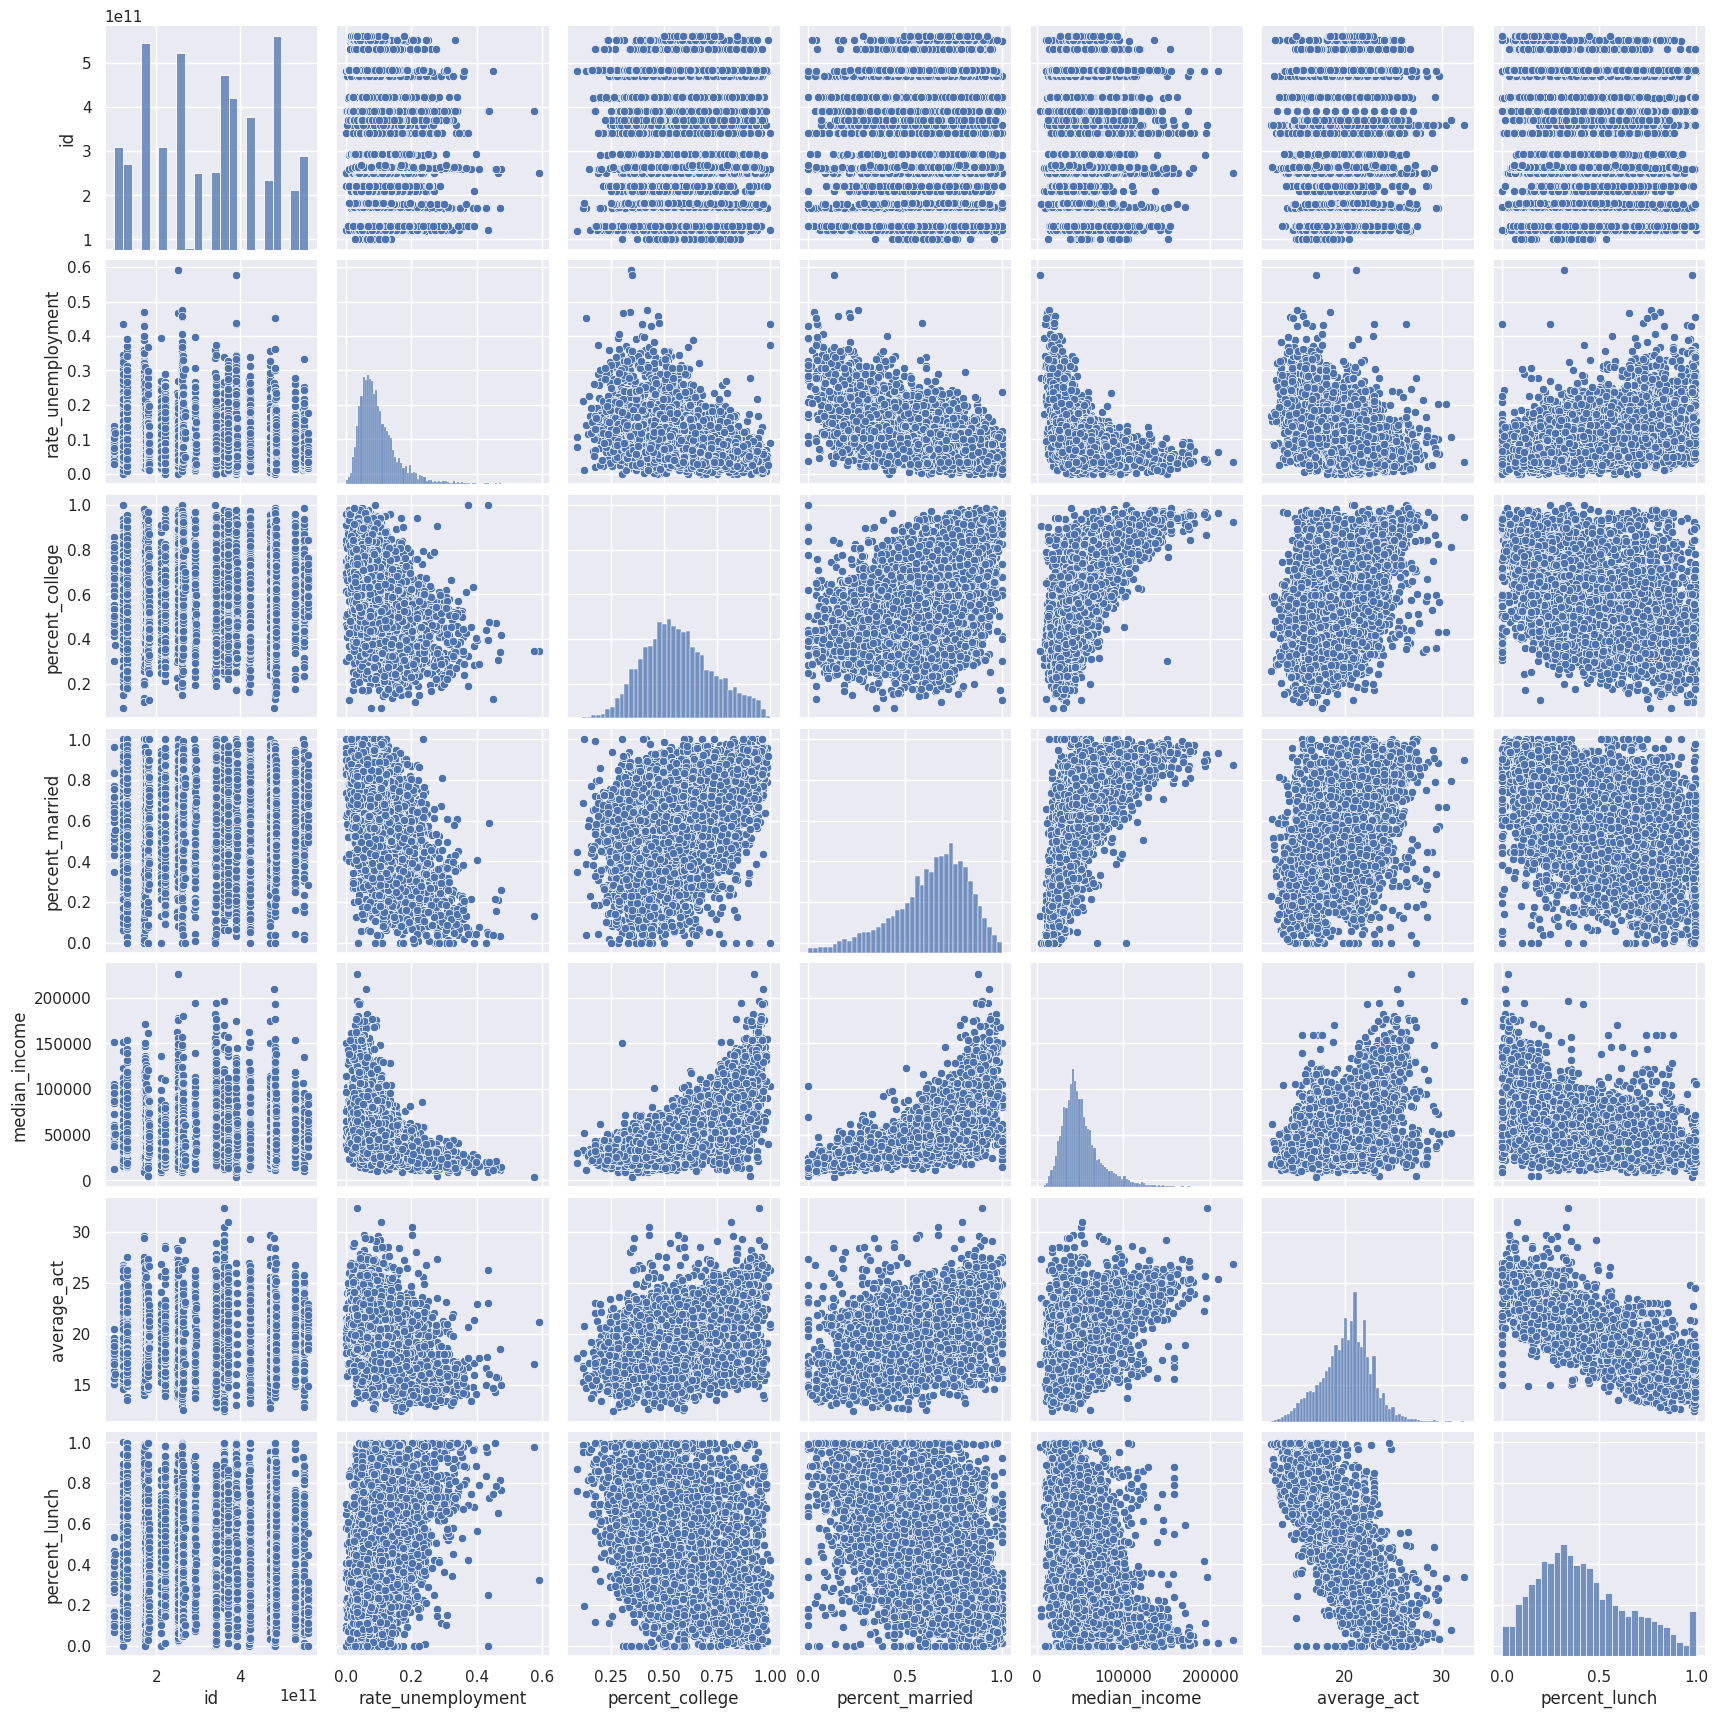

In [131]:
sns.set()
sns.pairplot(edgap)

There's a lot of data. The data set appears to contain variables with interesting correlations that can be used to answer our initial question.

## Join data frames
Perform an inner join on 'id' in edgap and 'id' in school_info.

In [132]:
df = edgap.merge(school_info, left_on='id', right_on='id')

In [133]:
df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level
0,1.000016e+11,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High
1,1.000080e+11,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High
2,1.000080e+11,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High
3,1.000170e+11,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High
4,1.000180e+11,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High
...,...,...,...,...,...,...,...,...,...,...,...,...
7870,5.605302e+11,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156,2016-2017,WY,82902,Regular School,High
7871,5.605690e+11,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871,2016-2017,WY,82833,Regular School,High
7872,5.605695e+11,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829,2016-2017,WY,82801,Regular School,High
7873,5.605762e+11,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583,2016-2017,WY,82935,Regular School,High


In [134]:
print("Rows lost during join: {}".format(edgap.shape[0]-df.shape[0]))

Rows lost during join: 88


It looks like we lost a few rows during the join, meaning either the info for an id in edgap was not in school_info or vice-versa. This has the added benefit of drastically decreaing the likelihood of an invalid id, since it has to also exist in school_info. The number of rows lost is very small, so this is totally fine.

### Check for duplicate ids

In [135]:
len(df['id']) - len(df['id'].unique())

0

There are none! Hooray!

## Identify missing values

Determine whether there are missing values in the data set.

In [136]:
missing = df.isna().sum()
missing

id                    0
rate_unemployment    14
percent_college      13
percent_married      24
median_income        20
average_act           0
percent_lunch         0
year                  0
state                 0
zip_code              0
school_type           0
school_level          0
dtype: int64

In [137]:
missing.sum()

71

There are 71 NaNs. Some imputation will need to be about those after the train test split.

## Train test split

We will use the test set approach to compare models predicting `average_act`.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/ML_dataset_training_validation_test_sets.png/800px-ML_dataset_training_validation_test_sets.png)

Split the data into training and testing sets. Keep 20% of the data for the test set.

In [138]:
train_df, test_df = train_test_split(df,shuffle = True, test_size = 0.2, random_state=17)

## Data imputation

 Section to use an imputation method to replace missing values in the columns corresponding to predictor variables in the analysis.

In [139]:
variables_to_impute = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch']

In [140]:
X = train_df[variables_to_impute]
imputer = IterativeImputer()
train_df[variables_to_impute] = imputer.fit_transform(X)

In [141]:
X = test_df[variables_to_impute]
imputer = IterativeImputer()
test_df[variables_to_impute] = imputer.fit_transform(X)

## Normalize Data

In [142]:
numeric_features = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch']

In [143]:
train_df_mean = train_df[numeric_features].mean()

In [144]:
train_df_std = train_df[numeric_features].std()

In [145]:
train_df[numeric_features] = (train_df[numeric_features] - train_df_mean) / train_df_std

In [146]:
test_df[numeric_features] = (test_df[numeric_features] - train_df_mean) / train_df_std

## Create relevant derived variables as new columns

Work in progress. This step will be returned to after exploring the data further.

## Export the clean .csv files

Export files with the training and testing data.

The following code exports each clean data set to a csv, and then copies it into the user's google drive.

In [147]:
train_df.to_csv('clean_edu_ineq_normalized_train.csv', index=False)

In [148]:
test_df.to_csv('clean_edu_ineq_normalized_test.csv', index=False)

In [149]:
train_df_mean.to_csv('clean_edu_ineq_train_mean.csv', index=False)

In [150]:
train_df_std.to_csv('clean_edu_ineq_train_std.csv', index=False)

In [151]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [152]:
!cp clean_edu_ineq_normalized_train.csv "drive/My Drive/"

In [153]:
!cp clean_edu_ineq_normalized_test.csv "drive/My Drive/"

In [154]:
!cp clean_edu_ineq_train_mean.csv "drive/My Drive/"

In [155]:
!cp clean_edu_ineq_train_std.csv "drive/My Drive/"